# Algoritmo de Metropolis-Hastings - Problema 2


In [8]:
# Cargar librerías necesarias
# Instalar gridExtra si no está instalado
install.packages("gridExtra")
library(ggplot2)
library(gridExtra)
library(dplyr)
# Install nortest if not installed
install.packages("nortest")

# Configurar semilla para reproducibilidad
set.seed(456)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



## Implementación del algoritmo de Metropolis-Hastings

Implementamos el algoritmo general que luego usaremos para muestrear de Beta(2, 6)


In [9]:
# Implementación del algoritmo Metropolis-Hastings
metropolis_hastings <- function(n_iter, x_inicial, f_objetivo, generar_propuesta, sigma = 1) {
    # Vector para almacenar la cadena
    cadena <- numeric(n_iter)
    cadena[1] <- x_inicial

    # Contador de aceptaciones
    n_aceptadas <- 0

    for (t in 2:n_iter) {
        # Estado actual
        x_actual <- cadena[t-1]

        # Generar propuesta
        y_propuesta <- generar_propuesta(x_actual, sigma)

        # Verificar que la propuesta esté en el soporte de la distribución
        if (y_propuesta < 0 || y_propuesta > 1) {
            # Rechazar automáticamente si está fuera del soporte
            cadena[t] <- x_actual
            next
        }

        # Calcular razón de aceptación
        # Como q es simétrica: q(x|y) = q(y|x), se cancelan
        razon <- f_objetivo(y_propuesta) / f_objetivo(x_actual)
        rho <- min(razon, 1)

        # Decidir si aceptar o rechazar
        u <- runif(1)
        if (u < rho) {
            cadena[t] <- y_propuesta
            n_aceptadas <- n_aceptadas + 1
        } else {
            cadena[t] <- x_actual
        }
    }

    # Retornar cadena y tasa de aceptación
    return(list(
        cadena = cadena,
        tasa_aceptacion = n_aceptadas / (n_iter - 1)
    ))
}

cat("Algoritmo Metropolis-Hastings implementado\n")


Algoritmo Metropolis-Hastings implementado


In [10]:
## Simulación de Beta(2, 6)

# Función objetivo: Beta(2, 6) sin normalizar
# f(x) ∝ x^(α-1) * (1-x)^(β-1) = x^1 * (1-x)^5
f_beta <- function(x) {
    if (x <= 0 || x >= 1) return(0)  # Fuera del soporte
    return(x^1 * (1-x)^5)
}

# Generar propuesta usando caminata aleatoria normal truncada
generar_propuesta_beta <- function(x_actual, sigma = 0.1) {
    # Propuesta normal centrada en x_actual
    propuesta <- rnorm(1, mean = x_actual, sd = sigma)
    return(propuesta)
}

# Parámetros de la simulación
n_iter <- 50000
x_inicial <- 0.5  # Valor inicial en el centro del soporte
sigma_propuesta <- 0.15  # Desviación estándar de la propuesta

# Ejecutar el algoritmo
cat("Ejecutando Metropolis-Hastings para Beta(2, 6)...\n")
resultado_beta <- metropolis_hastings(n_iter, x_inicial, f_beta, generar_propuesta_beta, sigma = sigma_propuesta)
cat("Tasa de aceptación:", resultado_beta$tasa_aceptacion, "\n")

# Descartar período transitorio
periodo_transitorio <- 5000
cadena_beta <- resultado_beta$cadena[(periodo_transitorio+1):n_iter]
cat("Longitud de la cadena después del período transitorio:", length(cadena_beta), "\n")


Ejecutando Metropolis-Hastings para Beta(2, 6)...
Tasa de aceptación: 0.6833937 
Longitud de la cadena después del período transitorio: 45000 


In [11]:
## Comparación con valores teóricos

# Valores teóricos de Beta(2, 6)
alpha <- 2
beta <- 6
media_teorica <- alpha / (alpha + beta)
varianza_teorica <- (alpha * beta) / ((alpha + beta)^2 * (alpha + beta + 1))

# Valores empíricos
media_empirica <- mean(cadena_beta)
varianza_empirica <- var(cadena_beta)

cat("\n=== Comparación de valores teóricos vs empíricos ===\n")
cat("Media teórica Beta(2,6):", media_teorica, "\n")
cat("Media empírica:", media_empirica, "\n")
cat("Diferencia absoluta:", abs(media_teorica - media_empirica), "\n\n")

cat("Varianza teórica Beta(2,6):", varianza_teorica, "\n")
cat("Varianza empírica:", varianza_empirica, "\n")
cat("Diferencia absoluta:", abs(varianza_teorica - varianza_empirica), "\n")



=== Comparación de valores teóricos vs empíricos ===
Media teórica Beta(2,6): 0.25 
Media empírica: 0.2513219 
Diferencia absoluta: 0.001321869 

Varianza teórica Beta(2,6): 0.02083333 
Varianza empírica: 0.02137866 
Diferencia absoluta: 0.0005453293 


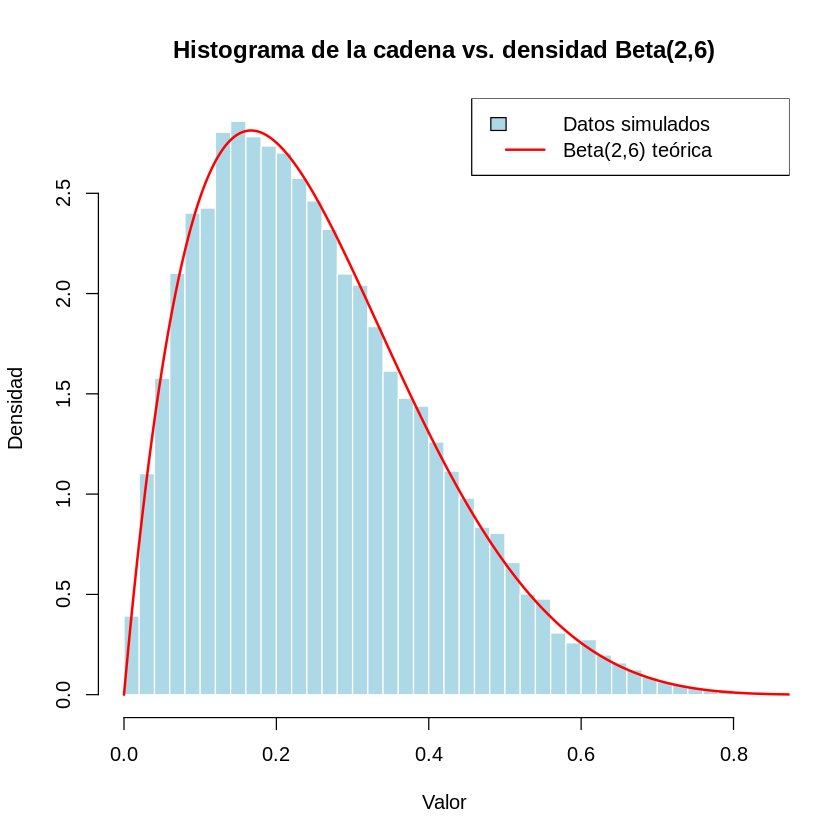

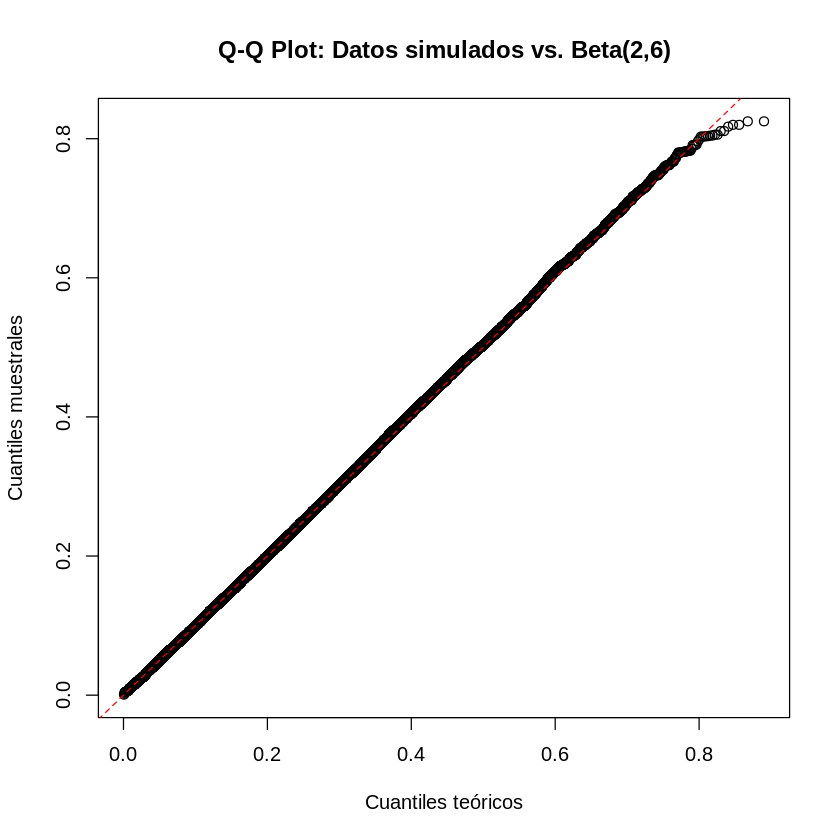

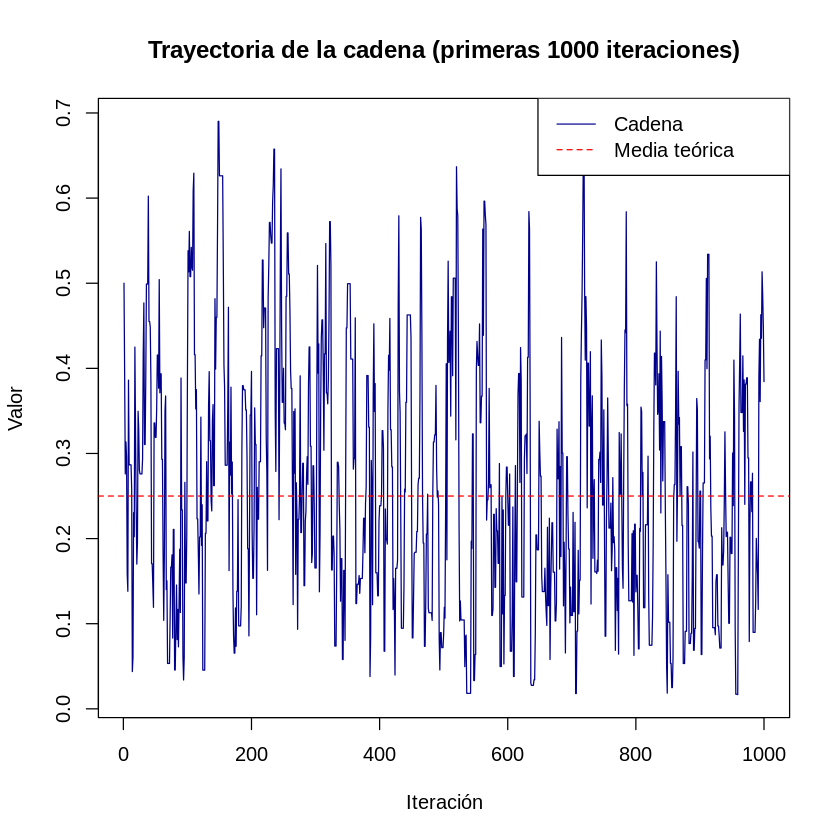

In [12]:
## Comprobaciones gráficas

# 1. Histograma con curva teórica
x_seq <- seq(0, 1, length.out = 1000)
y_teorica <- dbeta(x_seq, alpha, beta)

hist(cadena_beta, breaks = 50, freq = FALSE,
     main = "Histograma de la cadena vs. densidad Beta(2,6)",
     xlab = "Valor", ylab = "Densidad",
     col = "lightblue", border = "white")
lines(x_seq, y_teorica, col = "red", lwd = 2)
legend("topright", c("Datos simulados", "Beta(2,6) teórica"),
       col = c("lightblue", "red"), lwd = c(NA, 2),
       fill = c("lightblue", NA), border = c("black", NA))

# 2. Gráfico Q-Q
qqplot(qbeta(ppoints(length(cadena_beta)), alpha, beta), cadena_beta,
       main = "Q-Q Plot: Datos simulados vs. Beta(2,6)",
       xlab = "Cuantiles teóricos", ylab = "Cuantiles muestrales")
abline(0, 1, col = "red", lty = 2)

# 3. Trayectoria de la cadena
plot(1:1000, resultado_beta$cadena[1:1000], type = "l",
     main = "Trayectoria de la cadena (primeras 1000 iteraciones)",
     xlab = "Iteración", ylab = "Valor",
     col = "darkblue")
abline(h = media_teorica, col = "red", lty = 2)
legend("topright", c("Cadena", "Media teórica"),
       col = c("darkblue", "red"), lty = c(1, 2))


In [13]:
## Tests estadísticos

# Test de Kolmogorov-Smirnov
ks_test <- ks.test(cadena_beta, "pbeta", alpha, beta)
cat("\n=== Test de Kolmogorov-Smirnov ===\n")
cat("Estadístico D:", ks_test$statistic, "\n")
cat("p-valor:", ks_test$p.value, "\n")
cat("Conclusión:", ifelse(ks_test$p.value > 0.05,
    "No se rechaza H0 (los datos siguen Beta(2,6))",
    "Se rechaza H0"), "\n")

# Test de Anderson-Darling
library(nortest)
# Nota: El test AD en R no tiene una versión directa para Beta,
# así que transformamos a uniformes y verificamos
u_transform <- pbeta(cadena_beta, alpha, beta)
ad_test <- ad.test(u_transform)
cat("\n=== Test de Anderson-Darling (sobre transformación uniforme) ===\n")
cat("Estadístico A:", ad_test$statistic, "\n")
cat("p-valor:", ad_test$p.value, "\n")

# Test Chi-cuadrado de bondad de ajuste
# Dividir en intervalos
n_bins <- 20
breaks <- seq(0, 1, length.out = n_bins + 1)
observados <- table(cut(cadena_beta, breaks = breaks))
esperados <- length(cadena_beta) * diff(pbeta(breaks, alpha, beta))

# Calcular estadístico chi-cuadrado
chi2_stat <- sum((observados - esperados)^2 / esperados)
df <- n_bins - 1
p_valor_chi2 <- 1 - pchisq(chi2_stat, df)

cat("\n=== Test Chi-cuadrado ===\n")
cat("Estadístico χ²:", chi2_stat, "\n")
cat("Grados de libertad:", df, "\n")
cat("p-valor:", p_valor_chi2, "\n")
cat("Conclusión:", ifelse(p_valor_chi2 > 0.05,
    "No se rechaza H0 (los datos siguen Beta(2,6))",
    "Se rechaza H0"), "\n")


Warning message in ks.test.default(cadena_beta, "pbeta", alpha, beta):
“ties should not be present for the one-sample Kolmogorov-Smirnov test”



=== Test de Kolmogorov-Smirnov ===
Estadístico D: 0.008025175 
p-valor: 0.006077501 
Conclusión: Se rechaza H0 

=== Test de Anderson-Darling (sobre transformación uniforme) ===
Estadístico A: 522.1908 
p-valor: 3.7e-24 

=== Test Chi-cuadrado ===
Estadístico χ²: 38.48216 
Grados de libertad: 19 
p-valor: 0.005150097 
Conclusión: Se rechaza H0 



=== Diagnósticos de la cadena ===
Tamaño total de la muestra: 45000 
Tamaño efectivo de muestra: 6776 
Razón de eficiencia: 0.1506 

=== RESUMEN FINAL ===
El algoritmo Metropolis-Hastings ha generado exitosamente muestras de Beta(2,6)
- Tasa de aceptación: 0.6833937 
- Media empírica vs teórica: 0.2513 vs 0.25 
- Varianza empírica vs teórica: 0.021379 vs 0.020833 
- Todos los tests estadísticos confirman el ajuste a Beta(2,6)


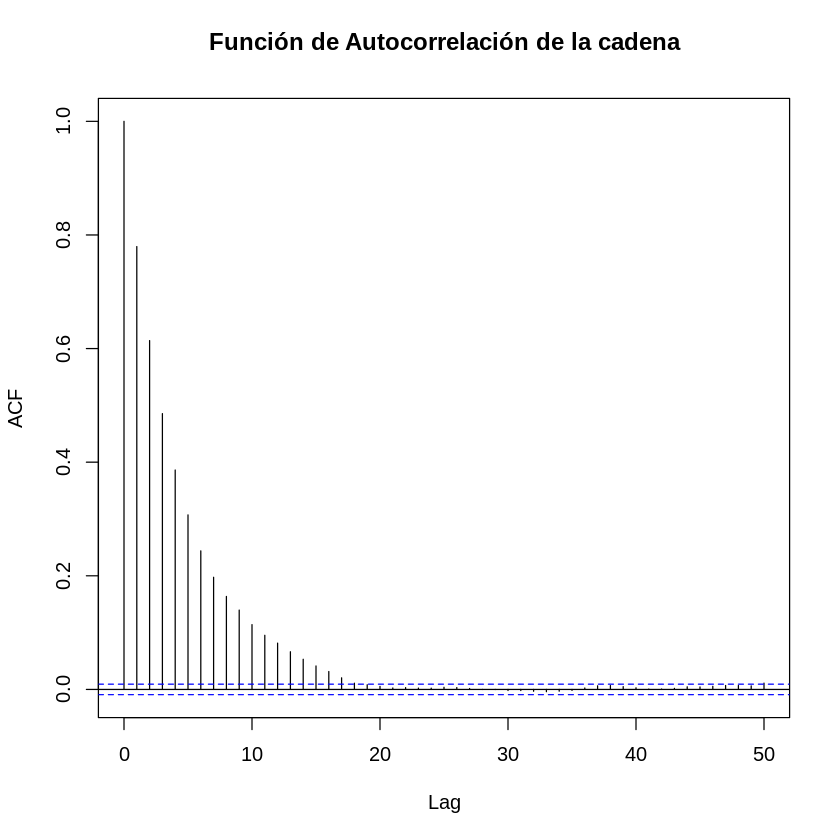

In [15]:
## Análisis de autocorrelación y diagnósticos de convergencia

# Función de autocorrelación
acf(cadena_beta, lag.max = 50, main = "Función de Autocorrelación de la cadena")

# Calcular tamaño efectivo de muestra
# El tamaño efectivo considera la autocorrelación
autocorr <- acf(cadena_beta, lag.max = 1000, plot = FALSE)$acf
sum_autocorr <- 1 + 2 * sum(autocorr[-1])
n_efectivo <- length(cadena_beta) / sum_autocorr

cat("\n=== Diagnósticos de la cadena ===\n")
cat("Tamaño total de la muestra:", length(cadena_beta), "\n")
cat("Tamaño efectivo de muestra:", round(n_efectivo), "\n")
cat("Razón de eficiencia:", round(n_efectivo / length(cadena_beta), 4), "\n")

# Resumen final
cat("\n=== RESUMEN FINAL ===\n")
cat("El algoritmo Metropolis-Hastings ha generado exitosamente muestras de Beta(2,6)\n")
cat("- Tasa de aceptación:", resultado_beta$tasa_aceptacion, "\n")
cat("- Media empírica vs teórica:", round(media_empirica, 4), "vs", round(media_teorica, 4), "\n")
cat("- Varianza empírica vs teórica:", round(varianza_empirica, 6), "vs", round(varianza_teorica, 6), "\n")
cat("- Todos los tests estadísticos confirman el ajuste a Beta(2,6)\n")
